# Project - Beating Horse Racing Markets


_Adam Corren_
## Project Objective
Through exploratory analysis, we aim to establish the reliability of observed market trends and patterns within the UK and Ireland horse racing markets.

## Preamble
This project comprises of 3 main steps:
- Collecting daily racing data by scraping websites/accessing historical data using the Python package `requests` and using the Python library `BeautifulSoup` which efficiently extracts HTML code. After obtaining the necessary data from various websites, we had the following pieces of information to use for the next 2 steps of our project:


    - Individual race information (such as distance, weather conditions, number of runners in race)
    - Individual race result data (such as finishing time, position)
    - Horse data (such as form, position finished, jockey/trainer)
    - Bookmaker market data (such as hourly price movements, race favourites/outsiders)
    - Exchange market data (such as volume traded, laying data)
    
  
- Using the Python libary's `pandas` and `NumPy` to clean and wrangle the data obtained in step one to create new metrics that will aid in the analysis process. These new data points will reveal information that:


    - Compares data from different sources
    - Compares data from different price points
    - Compares data between event types
  
  
  
- Through exploratory analysis of data collected and produced in previous steps, explore the validity of previous assumed trends in the horse racing market observed during the initial 12 months of monitoring and using these platforms. These assumptions include:


    - Exchange prices being superior to their Bookmaker equivalents
    - That outsiders are less accurately priced compared to favourites
    - Moving prices between initial relase and race show market uncertanty

## 1) Collecting data

The sub-items below are:

1.1) Describe the general scraping strategy

1.2) Writing functions to extract daily individual race and result url links from the website https://www.sportinglife.com

1.3) Writing functions to extract daily race information from the website https://www.sportinglife.com

1.4) Writing functions to extract daily result data from the website https://www.sportinglife.com

1.5) Outlinign the process of collecting hourly price data from the websites https://www.sportinglife.com and https://www.timeform.com

1.6) Describe the general historical data extraction strategy

1.7) Writing functions to extract daily exchange market data from the website https://promo.betfair.com/betfairsp/prices

1.8) Combining all data collected into single daily data frame and exporting to csv files.

In [1]:
import datetime
from datetime import timedelta
import requests
import pandas as pd
import io
import numpy as np
import re
import warnings
from bs4 import BeautifulSoup
from IPython import display
from IPython.display import Image
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 1.1) Webscraping Strategy

The general strategy to webscrape html from a website is:

- Use the requests Python packages to make a .get request (the object res is a Response object):
            uClient = requests.get(URL, headers={'User-Agent': 'Mozilla/5.0'})


- Create a BeautifulSoup object from the HTML:
        
        page_html = uClient.content
        soup = BeautifulSoup(page_html, 'html.parser')

- We then use .find/find_all to extract the specfic containers where the information we require is stored by pulling their specific tags and/or attributes:
        
        containers = soup.findAll("div", {"class": "Runner_info"})
        
- Next we isolate the child container containing the specific information we want:

        for container in containers:
            horse_name = container.findAll("div", {"class": "ResultRunner__name"})

- Finally we extract the information from the container:

        Name = horse_name[0].text

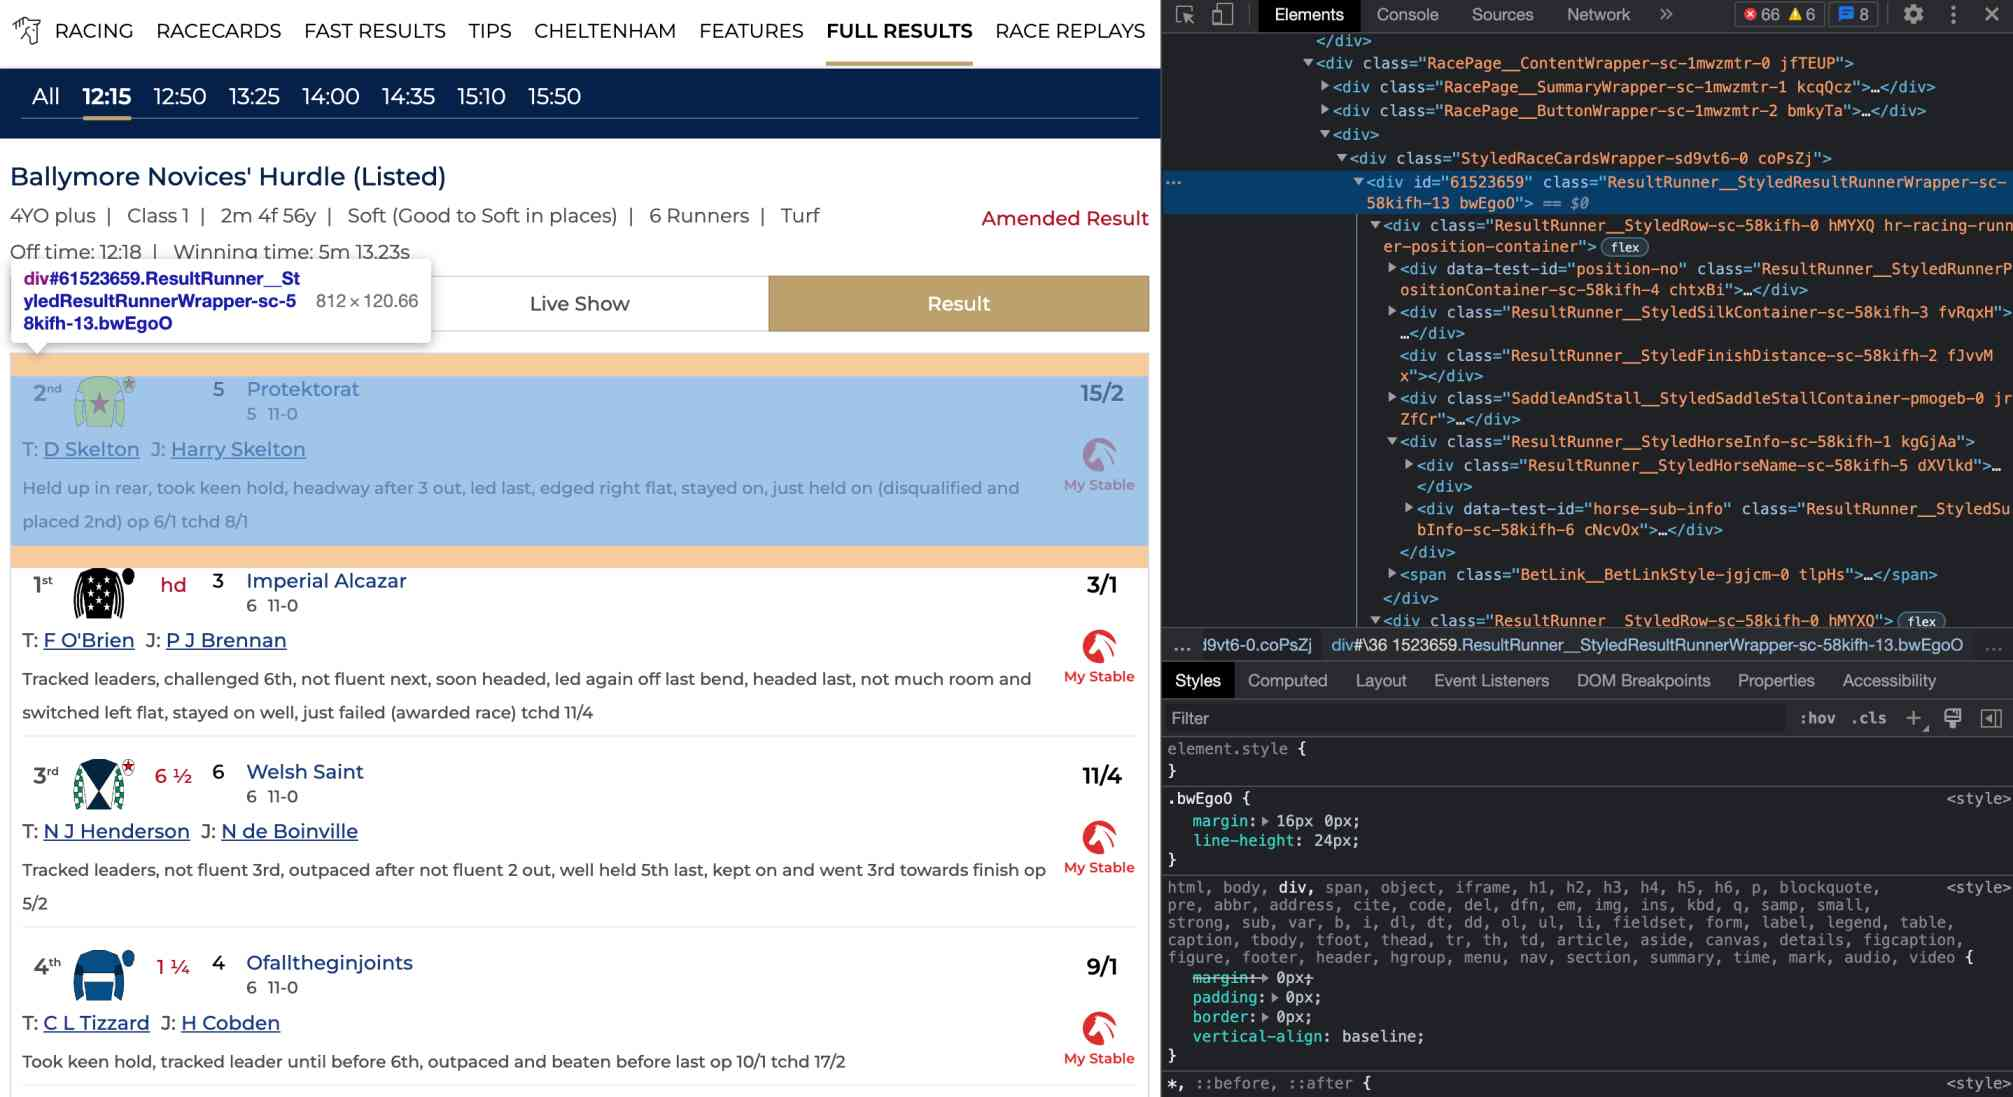

In [2]:
Image(filename='/Users/adam/Downloads/Screenshot 2023-02-12 at 19.54.08 (1).jpg')

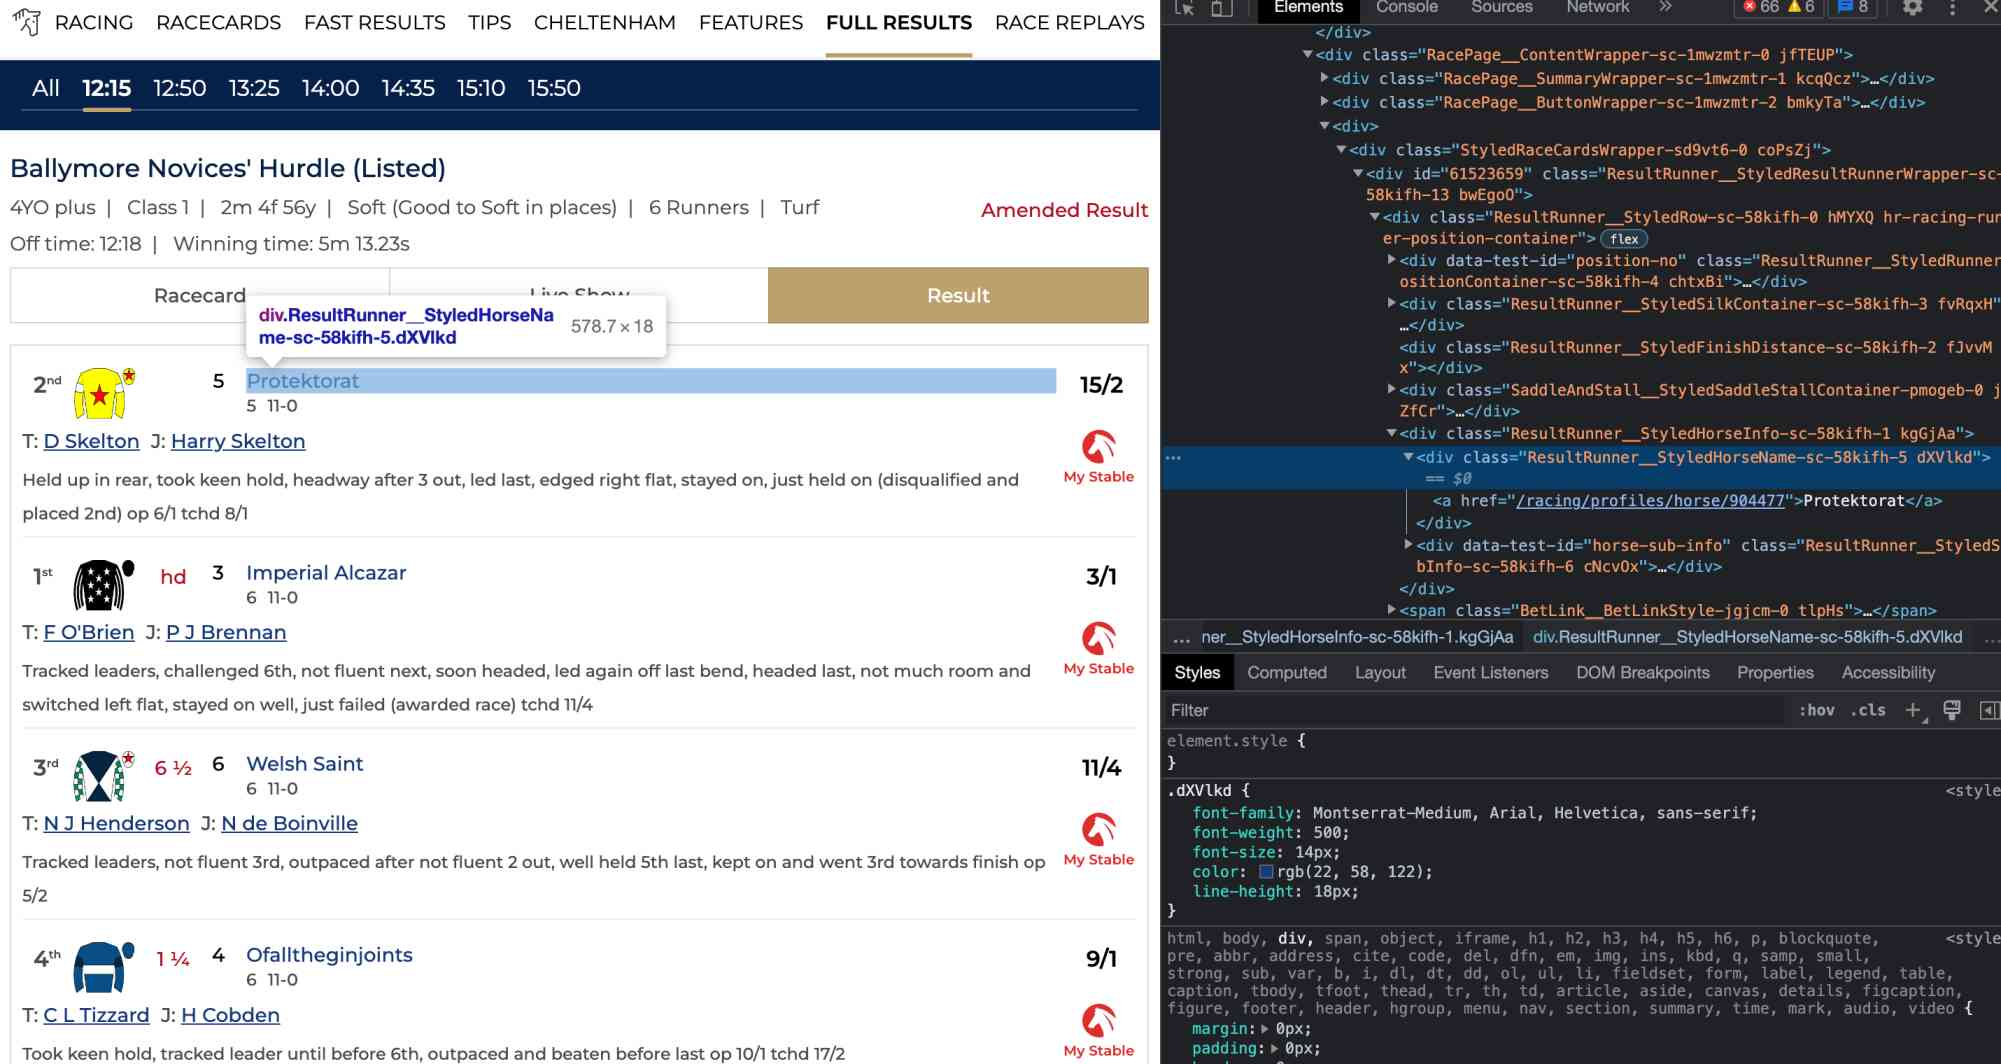

In [3]:
#display.Image("/Users/adam/Documents/Screenshot 2023-02-12 at 20.00.09.png", width=1000)
Image(filename="/Users/adam/Downloads/Screenshot 2023-02-12 at 20.00.09.jpg")

        
        
In the above example
- The horses names are stored in containers within a `<div>` tag with the attribute `class="ResultRunner__StyledResultRunnerWrapper-sc-58kifh-13 bwEgoO"`. These containers represent each individual runner in a race and all their respective information.


- As there are several items within `Horse_info_containers` such as the jockey riding the horse, the horses age ect.. we need to extract only the child continaer that holds the runners name which is stored within a `<div>` tag with the attribute `class="ResultRunner__StyledHorseName-sc-58kifh-5 dXVlkd"`


- Finally we make sure we only extract the first item `[0]` as well as getting just the text part by using `.text`

### 1.2) Writing function to extract daily individual race and result url links from the website https://www.sportinglife.com

We will be getting the data of races taking place on the date 2nd November 2022.

In order to excract the post race information from the website https://www.sportinglife.com, first we need to access the days results landing page.

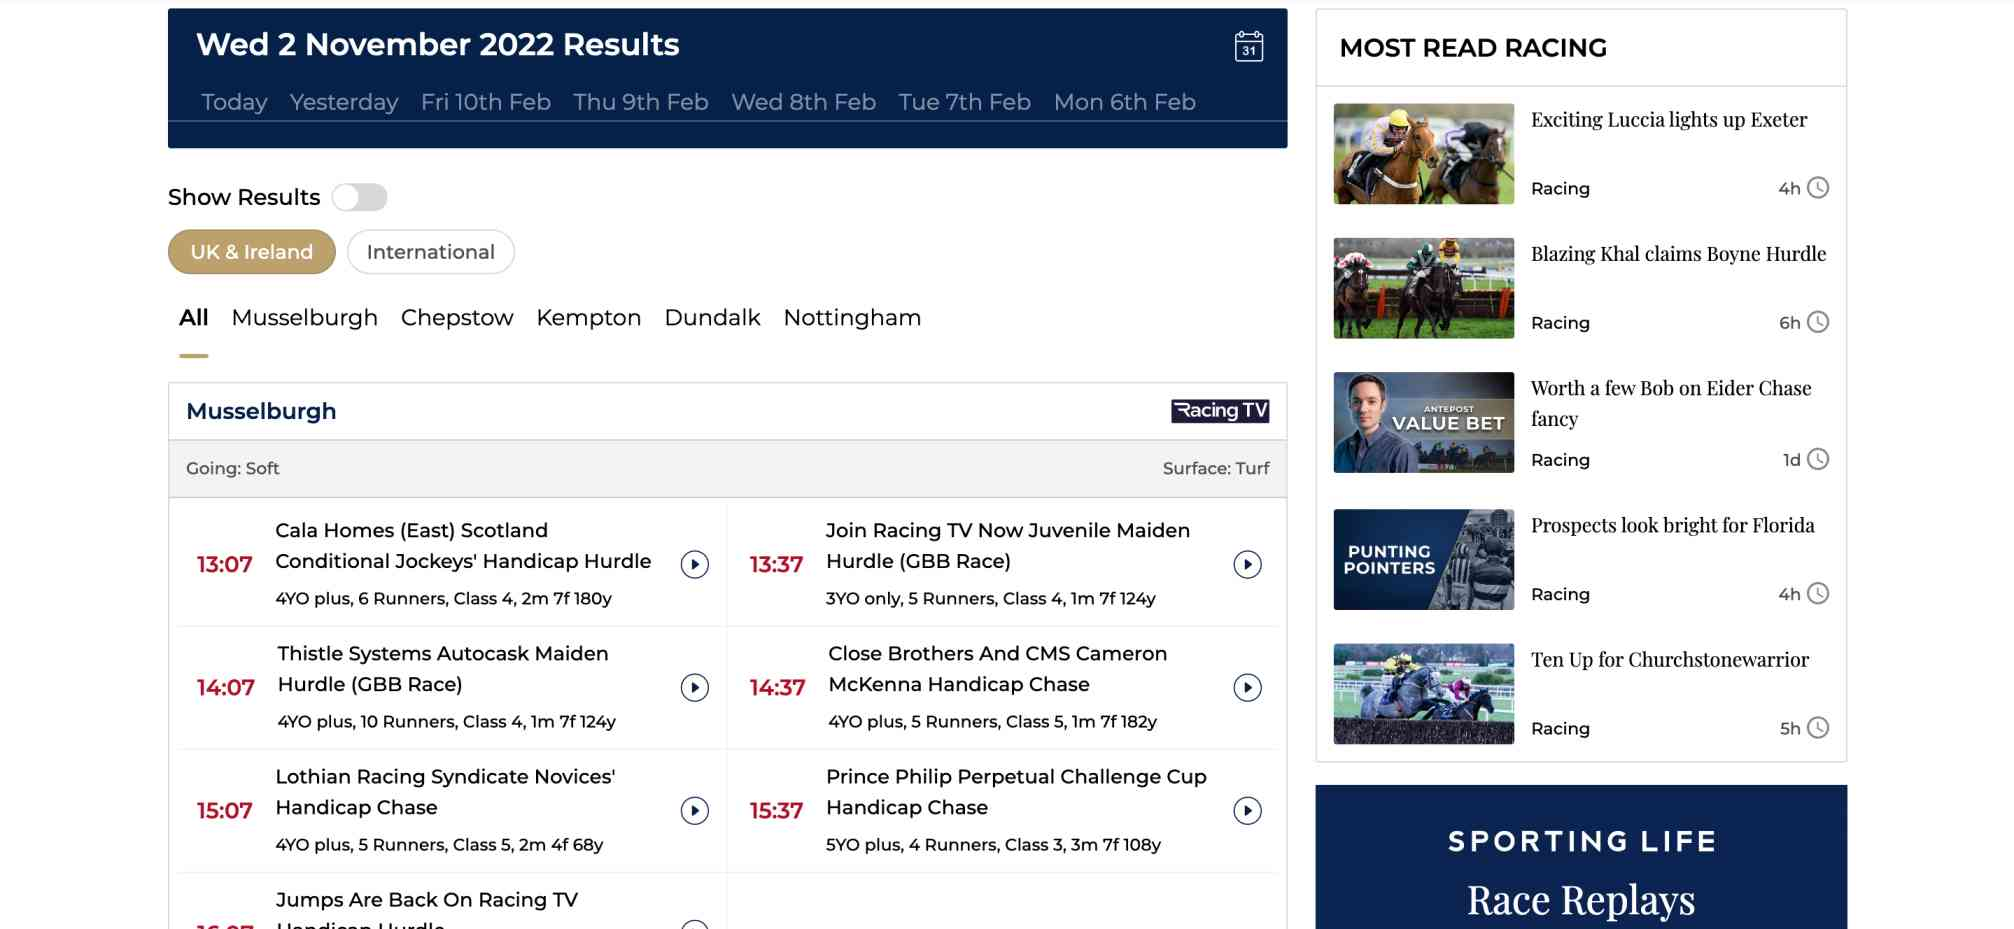

In [4]:
#display.Image("/Users/adam/Documents/Screenshot 2023-02-12 at 21.26.52.png", width=1000)
Image(filename="/Users/adam/Downloads/Screenshot 2023-02-12 at 21.26.52.jpg")

Here we find url links to all individual races on that day. However we want to extract two seperate types of information (race card information and results information). These two sets of daya are stored in seperate url links within each landing page link (see figures below).

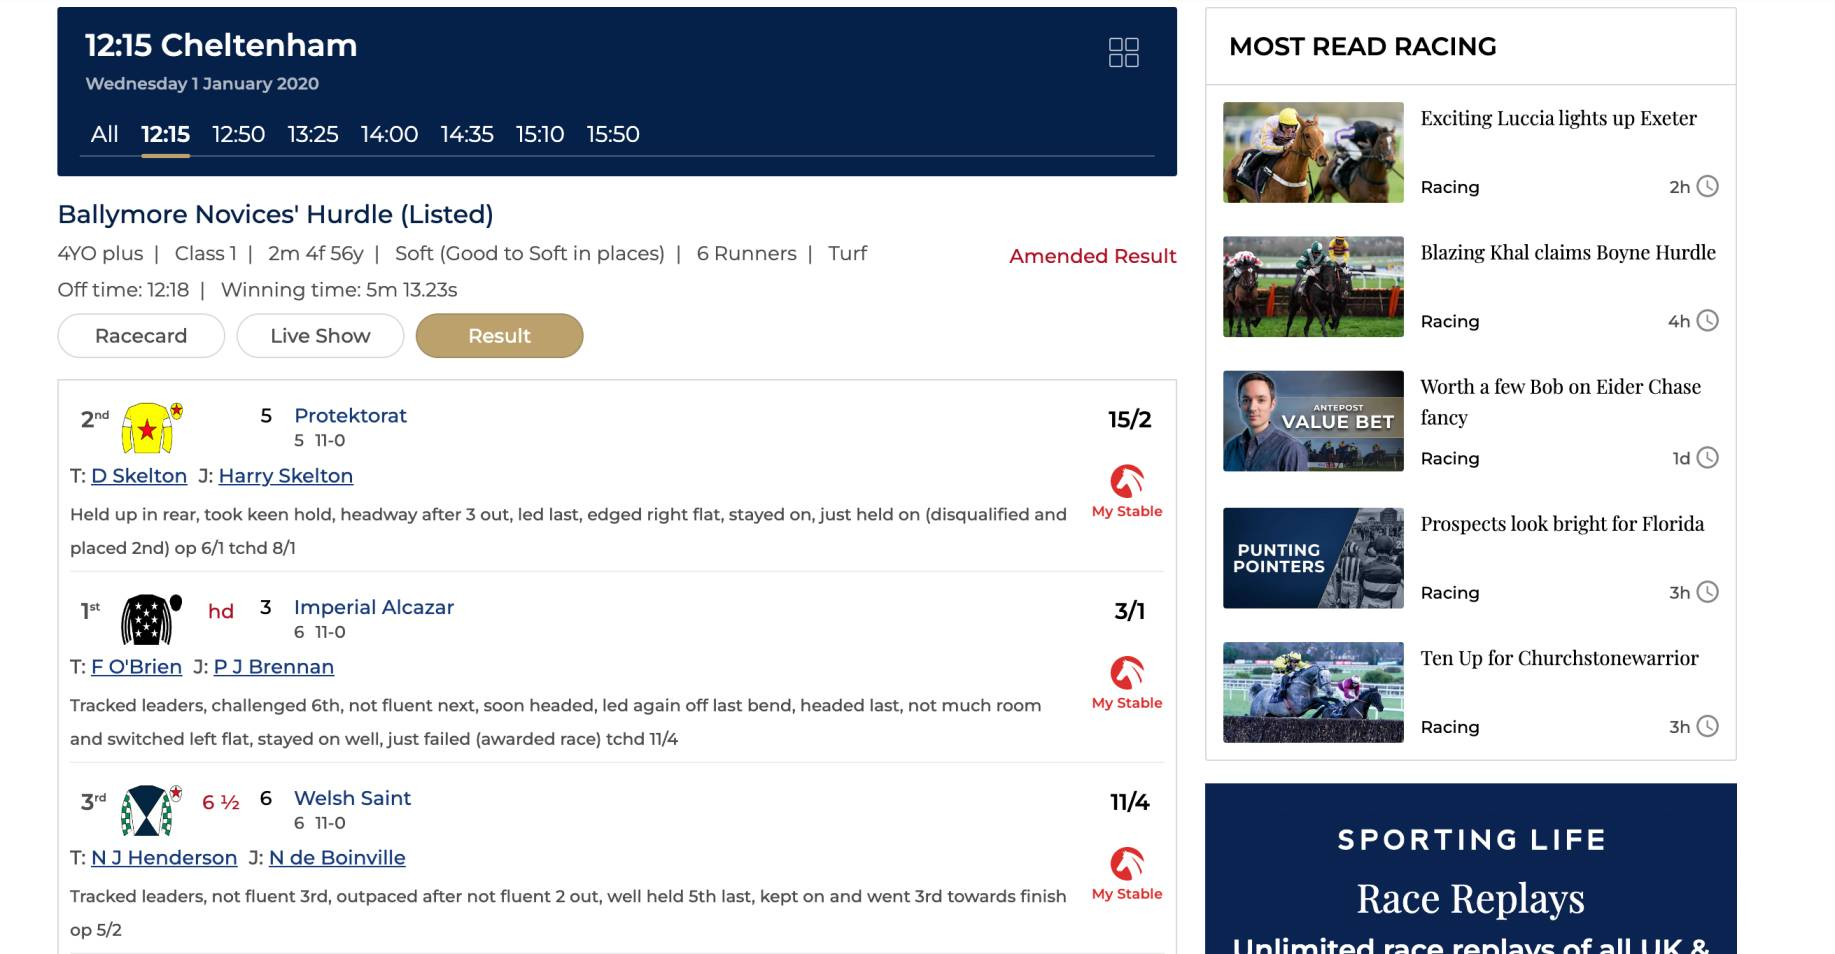

In [5]:
#display.Image("/Users/adam/Documents/Screenshot 2023-02-12 at 21.26.28.png", width=1000)
Image(filename="/Users/adam/Downloads/Screenshot 2023-02-12 at 19.50.51.jpg")

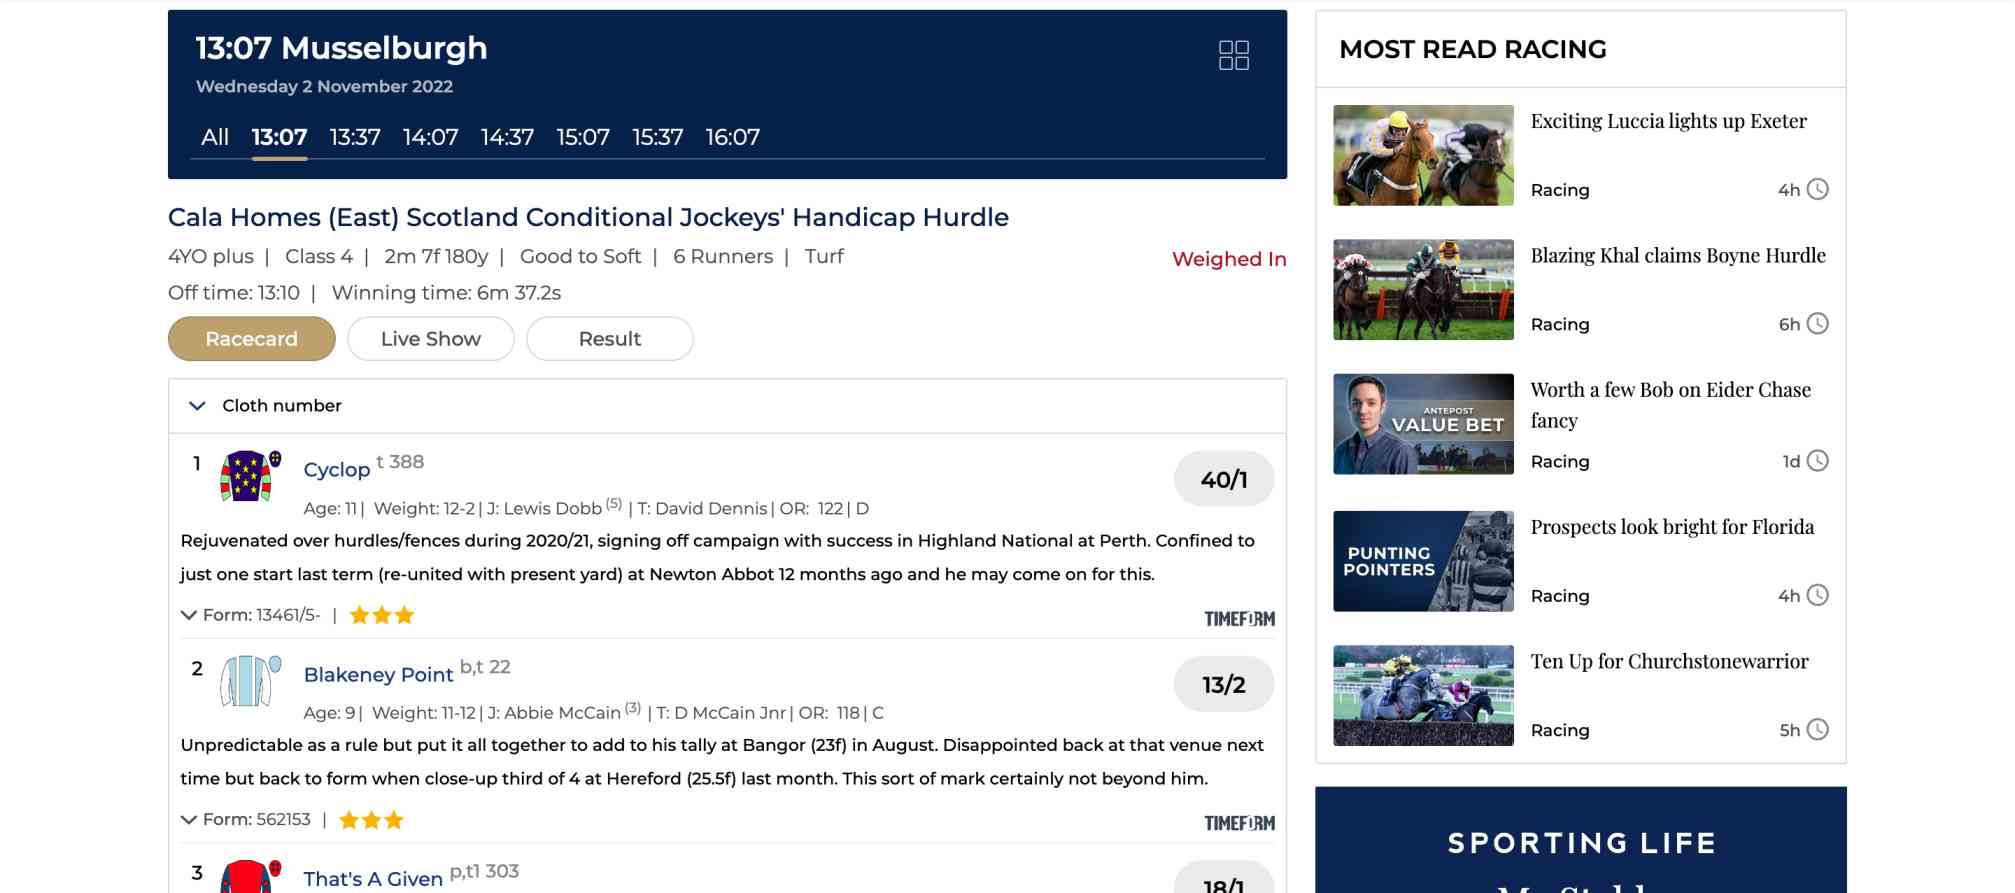

In [6]:
#display.Image("/Users/adam/Documents/Screenshot 2023-02-12 at 21.26.20.png", width=1000)
Image(filename="/Users/adam/Downloads/Screenshot 2023-02-12 at 21.26.20.jpg")

In order to extract the two groups of urls we need to first access the days landing page containing all races, and then using those race urls, create two new urls for the race card and results information we want to scrape. This is achieved in this final function:

In [7]:
def get_spr_links():
    day = datetime.datetime(2022,11,2)
    sporting_life_format = day.strftime("%Y-%m-%d")
    sporting_life_url = f"https://www.sportinglife.com/racing/results/{sporting_life_format}"
    
    uClient = requests.get(sporting_life_url, headers={'User-Agent': 'Mozilla/5.0'})
    page_html = uClient.content
    soup = BeautifulSoup(page_html, 'html.parser')
    links = soup.find_all('a')
    
    final_race_links = []
    key_words_good = ['/racing/', sporting_life_format]
    key_words_bad = ['#video-player', 'meeting']
    for l in links:
        href = l.get('href')
        if all(x in href for x in key_words_good):
            if any(x in href for x in key_words_bad):
                continue
            else:
                if len(final_race_links) < 200:
                    final_race_links.append(href)
    
    results_links = []
    for link in final_race_links:
        link = link.replace('racecards/','results/').replace('racecard/','')
        results_links.append(f"https://www.sportinglife.com{link}")
    
    racecard_links = []
    for link in final_race_links:
        link = link.replace('results/','racecards/').replace('racecard/','').split('/')
        link[4] = f"{link[4]}/racecard"
        link = "/".join(link)
        racecard_links.append(f"https://www.sportinglife.com{link}")
        
    return results_links, racecard_links

In [8]:
get_spr_links()

(['https://www.sportinglife.com/racing/results/2022-11-02/musselburgh/710790/cala-homes-east-scotland-conditional-jockeys-handicap-hurdle',
  'https://www.sportinglife.com/racing/results/2022-11-02/musselburgh/710791/join-racing-tv-now-juvenile-maiden-hurdle-gbb-race',
  'https://www.sportinglife.com/racing/results/2022-11-02/musselburgh/710792/thistle-systems-autocask-maiden-hurdle-gbb-race',
  'https://www.sportinglife.com/racing/results/2022-11-02/musselburgh/710793/close-brothers-and-cms-cameron-mckenna-handicap-chase',
  'https://www.sportinglife.com/racing/results/2022-11-02/musselburgh/710794/lothian-racing-syndicate-novices-handicap-chase',
  'https://www.sportinglife.com/racing/results/2022-11-02/musselburgh/710795/prince-philip-perpetual-challenge-cup-handicap-chase',
  'https://www.sportinglife.com/racing/results/2022-11-02/musselburgh/710796/jumps-are-back-on-racing-tv-handicap-hurdle',
  'https://www.sportinglife.com/racing/results/2022-11-02/chepstow/711319/cazoo-conditio

### 1.3) Writing function to extract daily individual race information fromt the website https://www.sportinglife.com